In [1]:
from pyspark.sql import SparkSession

In [2]:
features = ['other_pp','from_fk','from_ti','from_corner','from_counter','from_gk','from_keeper','from_ko',
            'header','corner_type','fk_type','pk_type',
            'half_volley_technique','volley_technique','lob_technique','overhead_technique','backheel_technique','diving_h_technique',
            'distance_to_goal', 'shot_angle', 'preferred_foot_shot', 'under_pressure',
            'shot_aerial_won','shot_first_time','shot_one_on_one','shot_open_goal','shot_follows_dribble','players_inside_area']
target = ['goal']

In [3]:
spark = SparkSession.builder.appName("xG6").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/27 02:05:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
events = spark.read.csv('Datas/events_shot.csv', header=True, inferSchema=True)

In [5]:
import xG_preprocessing as pp

In [6]:
from xG_training import ModelTrainer

In [7]:
train_data, test_data = pp.pre_training(events, features)

In [8]:
model = ModelTrainer('logistic',train_data,test_data)

24/12/27 02:06:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


ROC-AUC for max_iter=10: 0.8031428289240663
ROC-AUC for max_iter=20: 0.8040701032613133
ROC-AUC for max_iter=30: 0.804093841102907
ROC-AUC for max_iter=40: 0.8040953055608532
ROC-AUC for max_iter=50: 0.8040948287605915
ROC-AUC for max_iter=60: 0.8040926491022532
ROC-AUC for max_iter=70: 0.8040940454458763
ROC-AUC for max_iter=80: 0.80408328338283
ROC-AUC for max_iter=90: 0.8040920020161839
ROC-AUC for max_iter=100: 0.8040929896738683


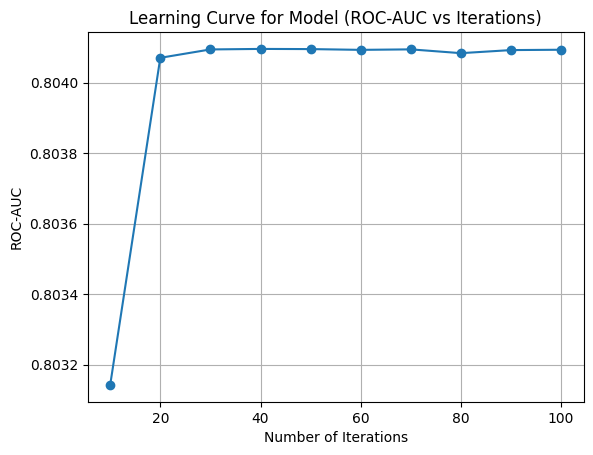

In [9]:
model.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [16]:
predictions = model.predictions

In [23]:
predictions = pp.goal_proba(predictions)

In [24]:
predictions.show()

+--------------------+---------+---------------+---------------+----------------+----------+-------------------+--------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+-----------------+------------+----+-------------+--------------------+--------------------+--------------------+----------+----------------+
|                  id|player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|other_pp|from_fk|from_ti|from_corner|from_counter|from_gk|from_keeper|from_ko|header|corner_type|fk_type|pk_type|half_volley_technique|volley_technique|lob_technique|overhead_technique|backheel_technique|diving_h_technique|under_pressure|shot_aerial_won|shot_first_time|shot_one_on_one|shot_o

In [20]:
from xG_evaluation import ModelEvaluation

In [21]:
me = ModelEvaluation(predictions,'goal','prediction')

In [25]:
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [26]:
me_r.get_all_metrics()

{'MSE': 0.004084430848560328,
 'RMSE': 0.06390955209168914,
 'MAE': 0.03188190552749279,
 'R2': 0.81839494997706}

In [22]:
me.get_all_metrics()

{'Accuracy': 0.9107839767051544,
 'Precision': 0.7577712609970675,
 'Recall': 0.2441882441882442,
 'Sensitivity': 0.2441882441882442,
 'Specificity': 0.9906480684751596,
 'F1': 0.3693539165237279,
 'FPR': 0.009351931524840361,
 'FNR': 0.7558117558117559}

In [16]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
input_size = len(features)
output_size = 2

# Define the Multilayer Perceptron classifier
layers = [input_size, 128, 64, 32, 16, output_size]

mlp = MultilayerPerceptronClassifier(featuresCol="features_vector", labelCol="goal", maxIter=100, layers=layers, blockSize=128, seed=1234)
xg_model = mlp.fit(train_data)

# Make predictions
predictions = xg_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="goal", rawPredictionCol="rawPrediction")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.8074684290112522


In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

input_size = len(features)
output_size = 2

mlp = MultilayerPerceptronClassifier(featuresCol="features_vector", labelCol="goal", seed=1234)

# Define the parameter grid
param_grid = (ParamGridBuilder()
              .addGrid(mlp.layers, [
                  [input_size, 128, 64, output_size],
                  [input_size, 128, 64, 32, output_size],
                  [input_size, 256, 128, 64, output_size]
              ])
              .addGrid(mlp.maxIter, [50, 100, 150])
              .addGrid(mlp.blockSize, [64, 128, 256])
              .build())

In [ ]:
# Set up cross-validator
evaluator = BinaryClassificationEvaluator(labelCol="goal", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
cv = CrossValidator(estimator=mlp, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

# Run cross-validation
cv_model = cv.fit(train_data)

# Best model and parameters
best_model = cv_model.bestModel
best_params = {param.name: value for param, value in cv_model.getEstimatorParamMaps()
               [cv_model.avgMetrics.index(max(cv_model.avgMetrics))].items()}

# Evaluate on test data
test_predictions = best_model.transform(test_data)
roc_auc = evaluator.evaluate(test_predictions)

print(f"Best ROC-AUC: {roc_auc}")
print(f"Best Parameters: {best_params}")

In [19]:
spark.stop()